In [455]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans

In [381]:
data = pd.read_csv('data/auto-mpg.data-original.txt', header=None,delim_whitespace=True)

In [382]:
cols = ['mpg','cylinders','displacement','horsepower','weight','acceleration','year','origin','name']

In [383]:
data.columns = cols

In [384]:
data = data.dropna().reset_index(drop=True)
data['year'] = (1900 + data['year']).astype(int)

In [385]:
data.ix[:,:5] = data.ix[:,:5].astype(int)
data['origin'] = data['origin'].astype(int)

# Predicting acceleration

In [386]:
regressors = data[['mpg','displacement','horsepower','weight']]

In [387]:
regressand = data['acceleration']

In [388]:
lr = LinearRegression()

In [389]:
lr.fit(regressors, regressand)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [390]:
data['predicted_acceleration'] = lr.predict(regressors)

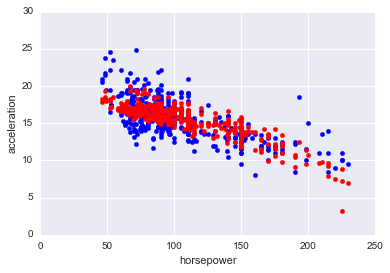

In [391]:
fig, ax = plt.subplots()
ax.scatter(data['horsepower'], data['acceleration'], color='b')
ax.scatter(data['horsepower'], data['predicted_acceleration'], color='r')
ax.set_xlabel('horsepower')
ax.set_ylabel('acceleration')

In [392]:
mean_squared_error(regressand, data['predicted_acceleration'])

2.9162037217445005

In [393]:
residuals = - data['acceleration'] + data['predicted_acceleration']

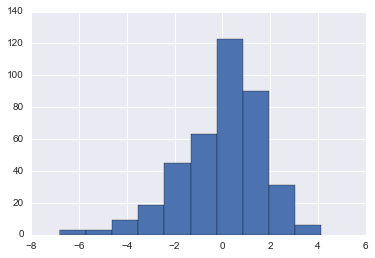

In [394]:
residuals.hist()

In [395]:
r2 = r2_score(data['acceleration'], data['predicted_acceleration'])

# Multiclass Classifier on Origin

In [396]:
dummy_cylinders = pd.get_dummies(data['cylinders'], prefix='cyl')

In [397]:
dummy_years = pd.get_dummies(data['year'], prefix='y')

In [398]:
dummies = pd.concat([dummy_cylinders, dummy_years], axis=1)

In [399]:
data = data.join(dummies)

In [400]:
categorical_cols = [col for col in data.columns if col.startswith('y_') or col.startswith('cyl_')]

In [401]:
x_train, x_test, y_train, y_test = train_test_split(data[categorical_cols],data['origin'],test_size=.2, random_state=1)

In [413]:
models = dict()
unique_origins = data['origin'].unique()
testing_probs = pd.DataFrame(columns = unique_origins)

In [414]:
for i in unique_origins:
    classifier = LogisticRegression()
    x = x_train
    y = y_train == i
    classifier.fit(x, y)
    models[i] = classifier
    testing_probs[i] = models[i].predict_proba(x_test)[:,1]

In [415]:
test_set = x_test.join(y_test).reset_index(drop=True)

In [416]:
predictions = testing_probs.idxmax(axis=1)

In [417]:
test_set['predicted_origin'] = predictions

In [418]:
correct = test_set['origin'] == test_set['predicted_origin']

In [423]:
len(test_set[correct]) / len(test_set)

0.759493670886076

In [424]:
probs = pd.DataFrame(columns = unique_origins)

In [425]:
for i in unique_origins:
    probs[i] = models[i].predict_proba(data[categorical_cols])[:,1]

In [427]:
data['predicted_origin'] = probs.idxmax(axis=1)

In [452]:
len(data[data['origin'] == data['predicted_origin']]) / len(data)

0.7142857142857143

# Clustering Cars

In [459]:
data = data[[i for i in data.columns if (i not in dummies.columns) and (i not in ['cylinders','year'])]]

In [483]:
data['hw_ratio'] = data['horsepower'] / data['weight']

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


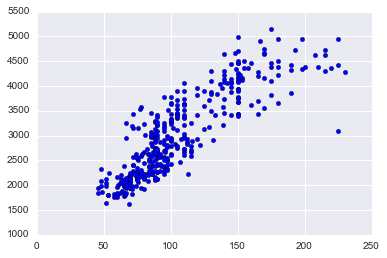

In [519]:
plt.scatter(data['horsepower'], data['weight'])

In [513]:
clustering = KMeans(n_clusters=3, random_state=1)

In [520]:
clustering.fit(data[['horsepower','weight']])

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [521]:
data['cluster'] = clustering.labels_

In [522]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

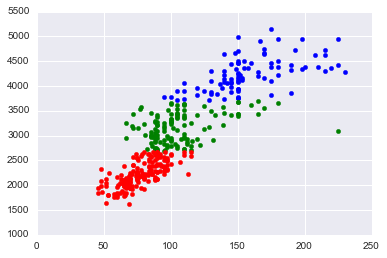

In [523]:
for n in range(3):
    clustered_data = data[data['cluster'] == n]
    plt.scatter(clustered_data['horsepower'], clustered_data['weight'], color=colors[n])

In [525]:
legend = {1:'North America', 2: 'Europe', 3:'Asia'}

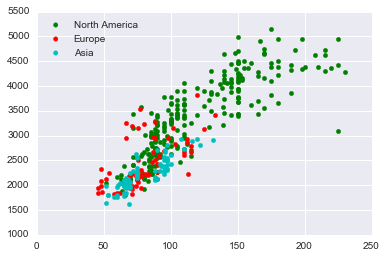

In [531]:
for n in range(1,4,1):
    clustered_data = data[data['origin'] == n]
    plt.scatter(clustered_data['horsepower'], clustered_data['weight'], color=colors[n], label=legend[n])
plt.legend(loc=2)